# FixMatch for Semi-Supervised Learning
> pytorch implementation of FixMatch paper as a fastai callback

Test run on STL10 dataset

In [1]:
!pip install timm -q

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from fastai.vision.all import *

In [3]:
from timm.data.auto_augment import rand_augment_transform

rand_aug = rand_augment_transform(
    config_str='rand-m9-mstd0.5', 
    hparams={}
)

In [4]:
class TransformFixMatch(object):
    def __init__(self, mean, std):
        self.weak = transforms.Compose([transforms.RandomHorizontalFlip()])
        self.strong = rand_aug
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)

In [5]:
class FixMatch(Callback):
    
    run_valid = False
    
    def __init__(self, unlabeled_trainloader, threshold=0.95, lambda_u=1.0, T=1.0):
        self.unlabeled_trainloader = unlabeled_trainloader
        self.unlabeled_iter = iter(self.unlabeled_trainloader)
        self.threshold = threshold
        self.lambda_u = lambda_u
        self.T = T
        
    def before_train(self):
        self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf
    
    def after_train(self):
        self.learn.loss_func = self.old_lf
        
    def before_batch(self):
        try:
            (self.inputs_u_w, self.inputs_u_s), _ = self.unlabeled_iter.next()
        except:
            self.unlabeled_iter = iter(self.unlabeled_trainloader)
            (self.inputs_u_w, self.inputs_u_s), _ = self.unlabeled_iter.next()
        self.inputs_u_w, self.inputs_u_s = to_device(self.inputs_u_w),to_device(self.inputs_u_s)
        self.learn.xb = tuple(L(torch.cat((self.learn.xb[0], self.inputs_u_w, self.inputs_u_s))))
        
    def after_pred(self):
        self.logits_x = self.pred[:self.dls.train.bs]
        self.logits_u_w, self.logits_u_s = self.pred[self.dls.train.bs:].chunk(2)
        
    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        Lx = self.old_lf(self.logits_x, *yb)
        pseudo_label = torch.softmax(self.logits_u_w.detach()/self.T, dim=-1)
        max_probs, targets_u = torch.max(pseudo_label, dim=-1)
        mask = max_probs.ge(self.threshold).float()
        with NoneReduce(self.old_lf) as lf:
            uloss = lf(self.logits_u_s, targets_u) * mask
        Lu = reduce_loss(uloss, 'mean')
        return Lx + self.lambda_u * Lu

In [6]:
stl10_mean = (0.4914, 0.4822, 0.4465)
stl10_std = (0.2471, 0.2435, 0.2616)

In [7]:
labeled_dataset = torchvision.datasets.STL10(root='/kaggle/input/stl10/', split='train', transform=None)

In [8]:
test_dataset = torchvision.datasets.STL10(root='/kaggle/input/stl10/', split='test', transform=None)

In [9]:
unlabeled_dataset = torchvision.datasets.STL10(root='/kaggle/input/stl10/', split='unlabeled', 
                                               transform=TransformFixMatch(stl10_mean,stl10_std))

In [10]:
labeled_dataset.data = labeled_dataset.data.transpose(0,2,3,1)
test_dataset.data = test_dataset.data.transpose(0,2,3,1)

In [11]:
n_all = len(labeled_dataset)+len(test_dataset)
len_tr = len(labeled_dataset)

In [12]:
def get_x(i): return labeled_dataset.data[i] if i <len_tr else test_dataset.data[i-len_tr]
def get_y(i): return labeled_dataset.classes[labeled_dataset.labels[i]] if i <len_tr else labeled_dataset.classes[test_dataset.labels[i-len_tr]]
def get_items(): return L(range(n_all))
db = DataBlock((ImageBlock, CategoryBlock),
               get_x=get_x,
               get_y=get_y,
               splitter=IndexSplitter(L(range(len_tr,n_all))),
               batch_tfms=[*aug_transforms(xtra_tfms=None), Normalize.from_stats(stl10_mean,stl10_std)] #use STL10 instead of imagenet
              )

In [13]:
batch_size = 64
mu = 7

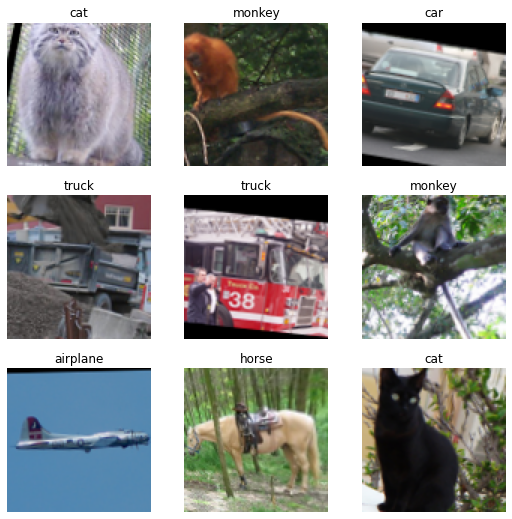

In [14]:
dls = db.dataloaders(L(range(n_all)), bs=batch_size);
dls.show_batch()

In [15]:
unlabeled_trainloader = torch.utils.data.DataLoader(
        unlabeled_dataset,
        batch_size=batch_size*mu,
        shuffle=True,
        drop_last=True)

In [18]:
model = create_cnn_model(resnet34, n_out=10, pretrained=True)
learn = Learner(dls, model, metrics=accuracy, loss_func=CrossEntropyLossFlat(), opt_func=SGD, 
                cbs=[FixMatch(unlabeled_trainloader)])

In [19]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.538423,0.713568,0.798750,01:45
1,0.800791,0.338963,0.895250,01:42
2,0.539217,0.305773,0.904250,01:42
